# StarDist 3D Training Jupyter Notebook - TiM2023

Modified from: https://github.com/stardist/stardist/tree/master/examples/3D

The Jupyter Notebook show how startdist model can be train on 3D images.
User need to modify the user settinings to optimize the training (see below)

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from tensorboard import program

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
# Prevent OOM Error by setting the max GPU vRAM avaible for tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [3]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$ User Settings $$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# IMPORTANT: raw and masks must have the same file name and be in two different input folders

# 1. User INPUT Settings
dir_raw = "C:/Users/CarloBeretta/Downloads/nuceli_3D/train/images/*"
dir_mask = "C:/Users/CarloBeretta/Downloads/nuceli_3D/train/masks/*"
dir_validation = "C:/Users/CarloBeretta/Downloads/nuceli_3D/train/images/*"
file_ext = ".tif"

# 2. Input parameters for StarDist training
quick_demo = False
augmenter = True
model_name = "stardist"
n_rays = 128
train_patch_size = (12, 256, 256)
train_batch_size = 2
train_epochs = 400
train_steps_per_epoch = 100

X = sorted(glob(dir_raw + file_ext))
Y = sorted(glob(dir_mask + file_ext))
validation_images = sorted(glob(dir_validation + file_ext)) # or X

# Check if arw and label images have the same file name
#assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
print("Number of Raw Images " + str(len(X)) + " Number of label Images " + str(len(Y)))

Number of Raw Images 13 Number of label Images 13


In [4]:
# Create the output model and image directory
def create_output_directory(results_dir):
    output_model_path = os.path.join(results_dir,'model_' + str(os.path.basename(os.path.normpath(results_dir))) + '_' + str(datetime.datetime.now()).replace(' ','_').replace('.','p').replace(':','T'))
    output_image_path = os.path.join(results_dir,'results_' + str(os.path.basename(os.path.normpath(results_dir))) + '_' + str(datetime.datetime.now()).replace(' ','_').replace('.','p').replace(':','T'))
    if not (os.path.exists(output_model_path) or os.path.exists(output_image_path)):
        os.mkdir(output_model_path)
        os.mkdir(output_image_path)
    return output_model_path, output_image_path

results_dir = os.path.normpath(os.path.dirname(X[0]))
output_model_path, output_image_path = create_output_directory(results_dir)
print('Creatining OUTPUT Model directory in the raw images path:', output_model_path)
print('Creatining OUTPUT Images directory in the raw images path:', output_image_path)

Creatining OUTPUT Model directory in the raw images path: C:\Users\CarloBeretta\Downloads\nuceli_3D\train\images\model_images_2023-02-09_11T46T58p722470
Creatining OUTPUT Images directory in the raw images path: C:\Users\CarloBeretta\Downloads\nuceli_3D\train\images\results_images_2023-02-09_11T46T58p722470


In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

Normalize images and fill small label holes.

In [6]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.99it/s]


Split into train and validation datasets.

In [7]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  13
- training:        11
- validation:       2


Training data consists of pairs of input image and label instances.

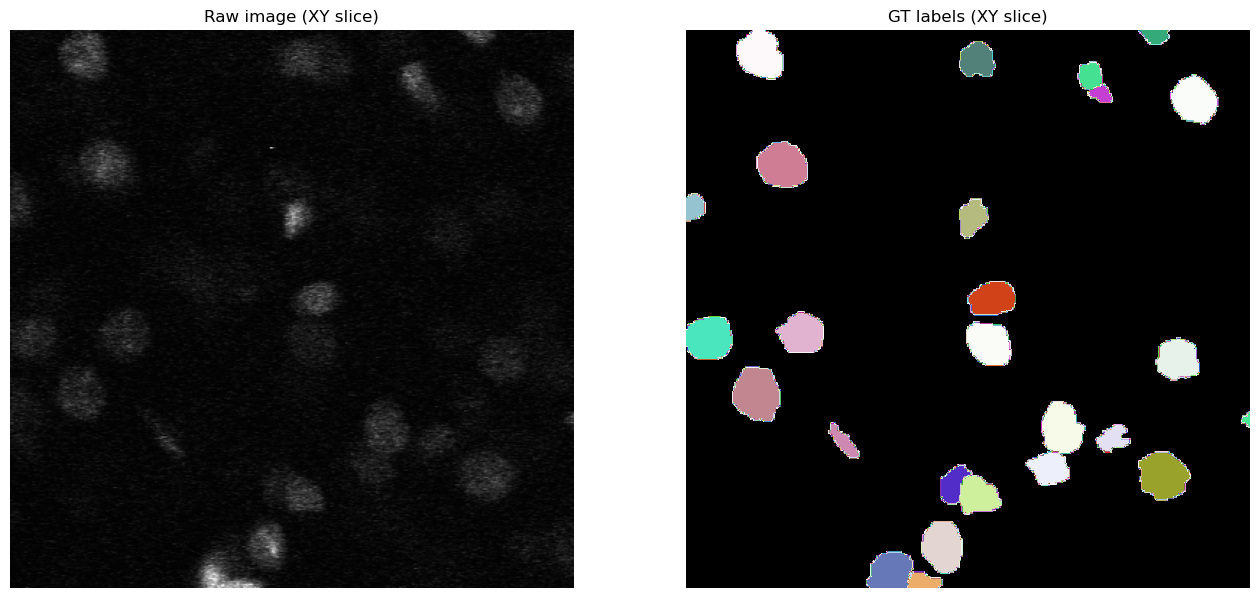

In [8]:
# Plot the first raw and mask image (i=0)
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
z = img.shape[0] // 2
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [9]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [10]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (4.375, 1.0, 1.0)


In [11]:
# 96 is a good default choice
n_rays = n_rays

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # resnet_n_blocks  = 5,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = train_patch_size, #24,96,96
    train_batch_size = train_batch_size,
    
    # Custom
    train_epochs = train_epochs,
    train_steps_per_epoch = train_steps_per_epoch,
)
print(conf)
vars(conf)

Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=129, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=128, grid=(1, 2, 2), anisotropy=(4.375, 1.0, 1.0), backbone='unet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 128, 'anisotropy': (4.375, 1.0, 1.0)}}, n_classes=None, unet_n_depth=2, unet_kernel_size=(3, 3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), train_patch_size=(12, 256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=2, train_n_val_patch

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 129,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 128,
 'grid': (1, 2, 2),
 'anisotropy': (4.375, 1.0, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 128, 'anisotropy': (4.375, 1.0, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (12, 256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_wei

In [12]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [13]:
model = StarDist3D(conf, name=model_name, basedir=output_model_path)

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [14]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

1/1 [==============================] - 0s 25ms/step


# Training

Applies augmentation to each batch of the data generated.

In [15]:
def random_flips_and_rotations(x, y, axis=None): 
    if axis is None:
        axis = tuple(range(y.ndim))
    axis = tuple(axis)
    assert x.ndim>=y.ndim
    #1. Rotation
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(y.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    x = x.transpose(transpose_axis + tuple(range(y.ndim, x.ndim))) 
    y = y.transpose(transpose_axis) 
    #2. Flips
    for ax in axis: 
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=ax)
            y = np.flip(y, axis=ax)
    return x, y 

# random_intensity_change
def random_uniform_noise(x):
    #3. Intensity                   
    x = x*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return x

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_flips_and_rotations(x, y, axis=(1,2))
    x = random_uniform_noise(x)
    return x, y

augmenter = augmenter

Training progress can be monitord using [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard).

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

In [16]:
# Open tensorboard log file
log_out = os.path.join(output_model_path, model_name) + '/logs'
log_out = str(log_out.replace('\\', '/'))
print('Tensorboard log file path', log_out)
%reload_ext tensorboard
%tensorboard --logdir=$log_out --host='localhost' --port 6008 #5051 #--logdir=. --port 6008

Tensorboard log file path C:/Users/CarloBeretta/Downloads/nuceli_3D/train/images/model_images_2023-02-09_11T46T58p722470/stardist/logs


In [ ]:
# Very usefull for testing StarDist installation
quick_demo = quick_demo

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
Cause: Unable to locate the source code of <function _gcd_import at 0x00000168434413A0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x00000168434413A0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate 

Epoch 12/400
100/100 [==============================] - 137s 1s/step - loss: 0.7004 - prob_loss: 0.0940 - dist_loss: 3.0317 - prob_kld: 0.0363 - dist_relevant_mae: 3.0310 - dist_relevant_mse: 19.6486 - dist_dist_iou_metric: 0.5430 - val_loss: 0.7218 - val_prob_loss: 0.0621 - val_dist_loss: 3.2984 - val_prob_kld: 0.0176 - val_dist_relevant_mae: 3.2978 - val_dist_relevant_mse: 21.5496 - val_dist_dist_iou_metric: 0.4812 - lr: 3.0000e-04
Epoch 13/400
100/100 [==============================] - 138s 1s/step - loss: 0.6916 - prob_loss: 0.0911 - dist_loss: 3.0022 - prob_kld: 0.0331 - dist_relevant_mae: 3.0015 - dist_relevant_mse: 19.7491 - dist_dist_iou_metric: 0.5503 - val_loss: 0.6403 - val_prob_loss: 0.0595 - val_dist_loss: 2.9040 - val_prob_kld: 0.0150 - val_dist_relevant_mae: 2.9034 - val_dist_relevant_mse: 17.0002 - val_dist_dist_iou_metric: 0.5521 - lr: 3.0000e-04
Epoch 14/400
100/100 [==============================] - 145s 1s/step - loss: 0.6900 - prob_loss: 0.0971 - dist_loss: 2.9648 

Epoch 25/400
100/100 [==============================] - 142s 1s/step - loss: 0.6133 - prob_loss: 0.0860 - dist_loss: 2.6367 - prob_kld: 0.0264 - dist_relevant_mae: 2.6361 - dist_relevant_mse: 15.8883 - dist_dist_iou_metric: 0.6001 - val_loss: 0.6113 - val_prob_loss: 0.0588 - val_dist_loss: 2.7624 - val_prob_kld: 0.0143 - val_dist_relevant_mae: 2.7618 - val_dist_relevant_mse: 15.0770 - val_dist_dist_iou_metric: 0.5677 - lr: 3.0000e-04
Epoch 26/400
100/100 [==============================] - 141s 1s/step - loss: 0.6015 - prob_loss: 0.0876 - dist_loss: 2.5695 - prob_kld: 0.0273 - dist_relevant_mae: 2.5689 - dist_relevant_mse: 14.9458 - dist_dist_iou_metric: 0.6084 - val_loss: 0.6132 - val_prob_loss: 0.0622 - val_dist_loss: 2.7547 - val_prob_kld: 0.0178 - val_dist_relevant_mae: 2.7541 - val_dist_relevant_mse: 14.8759 - val_dist_dist_iou_metric: 0.5697 - lr: 3.0000e-04
Epoch 27/400
100/100 [==============================] - 144s 1s/step - loss: 0.5929 - prob_loss: 0.0888 - dist_loss: 2.5205 

Epoch 38/400
100/100 [==============================] - 138s 1s/step - loss: 0.5631 - prob_loss: 0.0831 - dist_loss: 2.3998 - prob_kld: 0.0242 - dist_relevant_mae: 2.3992 - dist_relevant_mse: 13.4791 - dist_dist_iou_metric: 0.6289 - val_loss: 0.5378 - val_prob_loss: 0.0577 - val_dist_loss: 2.4004 - val_prob_kld: 0.0133 - val_dist_relevant_mae: 2.3999 - val_dist_relevant_mse: 11.9113 - val_dist_dist_iou_metric: 0.6213 - lr: 3.0000e-04
Epoch 39/400
100/100 [==============================] - 141s 1s/step - loss: 0.5704 - prob_loss: 0.0849 - dist_loss: 2.4275 - prob_kld: 0.0252 - dist_relevant_mae: 2.4268 - dist_relevant_mse: 13.4988 - dist_dist_iou_metric: 0.6276 - val_loss: 0.6799 - val_prob_loss: 0.0573 - val_dist_loss: 3.1128 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 3.1122 - val_dist_relevant_mse: 18.4230 - val_dist_dist_iou_metric: 0.5142 - lr: 3.0000e-04
Epoch 40/400
100/100 [==============================] - 136s 1s/step - loss: 0.5587 - prob_loss: 0.0825 - dist_loss: 2.3811 

Epoch 51/400
100/100 [==============================] - 141s 1s/step - loss: 0.5501 - prob_loss: 0.0843 - dist_loss: 2.3292 - prob_kld: 0.0238 - dist_relevant_mae: 2.3286 - dist_relevant_mse: 13.0229 - dist_dist_iou_metric: 0.6427 - val_loss: 0.5622 - val_prob_loss: 0.0619 - val_dist_loss: 2.5017 - val_prob_kld: 0.0174 - val_dist_relevant_mae: 2.5011 - val_dist_relevant_mse: 12.8140 - val_dist_dist_iou_metric: 0.6044 - lr: 3.0000e-04
Epoch 52/400
100/100 [==============================] - 138s 1s/step - loss: 0.5354 - prob_loss: 0.0829 - dist_loss: 2.2628 - prob_kld: 0.0230 - dist_relevant_mae: 2.2622 - dist_relevant_mse: 12.0374 - dist_dist_iou_metric: 0.6501 - val_loss: 0.5299 - val_prob_loss: 0.0609 - val_dist_loss: 2.3451 - val_prob_kld: 0.0164 - val_dist_relevant_mae: 2.3445 - val_dist_relevant_mse: 11.4711 - val_dist_dist_iou_metric: 0.6340 - lr: 3.0000e-04
Epoch 53/400
100/100 [==============================] - 133s 1s/step - loss: 0.5562 - prob_loss: 0.0822 - dist_loss: 2.3702 

Epoch 64/400
100/100 [==============================] - 140s 1s/step - loss: 0.5244 - prob_loss: 0.0804 - dist_loss: 2.2197 - prob_kld: 0.0216 - dist_relevant_mae: 2.2191 - dist_relevant_mse: 11.7623 - dist_dist_iou_metric: 0.6535 - val_loss: 0.5692 - val_prob_loss: 0.0596 - val_dist_loss: 2.5479 - val_prob_kld: 0.0151 - val_dist_relevant_mae: 2.5474 - val_dist_relevant_mse: 13.3161 - val_dist_dist_iou_metric: 0.5998 - lr: 3.0000e-04
Epoch 65/400
100/100 [==============================] - 139s 1s/step - loss: 0.5234 - prob_loss: 0.0794 - dist_loss: 2.2198 - prob_kld: 0.0217 - dist_relevant_mae: 2.2192 - dist_relevant_mse: 11.6482 - dist_dist_iou_metric: 0.6542 - val_loss: 0.4936 - val_prob_loss: 0.0573 - val_dist_loss: 2.1814 - val_prob_kld: 0.0128 - val_dist_relevant_mae: 2.1808 - val_dist_relevant_mse: 10.0307 - val_dist_dist_iou_metric: 0.6596 - lr: 3.0000e-04
Epoch 66/400
100/100 [==============================] - 144s 1s/step - loss: 0.5395 - prob_loss: 0.0857 - dist_loss: 2.2691 

Epoch 77/400
100/100 [==============================] - 139s 1s/step - loss: 0.5028 - prob_loss: 0.0787 - dist_loss: 2.1206 - prob_kld: 0.0205 - dist_relevant_mae: 2.1200 - dist_relevant_mse: 10.8537 - dist_dist_iou_metric: 0.6694 - val_loss: 0.5260 - val_prob_loss: 0.0661 - val_dist_loss: 2.2994 - val_prob_kld: 0.0216 - val_dist_relevant_mae: 2.2988 - val_dist_relevant_mse: 11.2395 - val_dist_dist_iou_metric: 0.6410 - lr: 3.0000e-04
Epoch 78/400
100/100 [==============================] - 139s 1s/step - loss: 0.5184 - prob_loss: 0.0794 - dist_loss: 2.1948 - prob_kld: 0.0212 - dist_relevant_mae: 2.1942 - dist_relevant_mse: 11.4539 - dist_dist_iou_metric: 0.6598 - val_loss: 0.5250 - val_prob_loss: 0.0596 - val_dist_loss: 2.3273 - val_prob_kld: 0.0151 - val_dist_relevant_mae: 2.3267 - val_dist_relevant_mse: 11.2770 - val_dist_dist_iou_metric: 0.6335 - lr: 3.0000e-04
Epoch 79/400
100/100 [==============================] - 139s 1s/step - loss: 0.4983 - prob_loss: 0.0777 - dist_loss: 2.1031 

Epoch 90/400
100/100 [==============================] - 142s 1s/step - loss: 0.4997 - prob_loss: 0.0792 - dist_loss: 2.1025 - prob_kld: 0.0205 - dist_relevant_mae: 2.1020 - dist_relevant_mse: 10.5397 - dist_dist_iou_metric: 0.6742 - val_loss: 0.4839 - val_prob_loss: 0.0567 - val_dist_loss: 2.1360 - val_prob_kld: 0.0122 - val_dist_relevant_mae: 2.1355 - val_dist_relevant_mse: 10.4018 - val_dist_dist_iou_metric: 0.6761 - lr: 3.0000e-04
Epoch 91/400
100/100 [==============================] - 143s 1s/step - loss: 0.5099 - prob_loss: 0.0830 - dist_loss: 2.1347 - prob_kld: 0.0226 - dist_relevant_mae: 2.1341 - dist_relevant_mse: 11.0060 - dist_dist_iou_metric: 0.6694 - val_loss: 0.5288 - val_prob_loss: 0.0599 - val_dist_loss: 2.3442 - val_prob_kld: 0.0155 - val_dist_relevant_mae: 2.3437 - val_dist_relevant_mse: 11.2004 - val_dist_dist_iou_metric: 0.6282 - lr: 3.0000e-04
Epoch 92/400
100/100 [==============================] - 143s 1s/step - loss: 0.4976 - prob_loss: 0.0802 - dist_loss: 2.0870 

Epoch 103/400
100/100 [==============================] - 143s 1s/step - loss: 0.4941 - prob_loss: 0.0807 - dist_loss: 2.0674 - prob_kld: 0.0199 - dist_relevant_mae: 2.0668 - dist_relevant_mse: 10.2691 - dist_dist_iou_metric: 0.6792 - val_loss: 0.5443 - val_prob_loss: 0.0600 - val_dist_loss: 2.4216 - val_prob_kld: 0.0156 - val_dist_relevant_mae: 2.4210 - val_dist_relevant_mse: 11.8297 - val_dist_dist_iou_metric: 0.6227 - lr: 3.0000e-04
Epoch 104/400
100/100 [==============================] - 138s 1s/step - loss: 0.4914 - prob_loss: 0.0779 - dist_loss: 2.0672 - prob_kld: 0.0200 - dist_relevant_mae: 2.0667 - dist_relevant_mse: 10.0581 - dist_dist_iou_metric: 0.6773 - val_loss: 0.4992 - val_prob_loss: 0.0588 - val_dist_loss: 2.2024 - val_prob_kld: 0.0143 - val_dist_relevant_mae: 2.2018 - val_dist_relevant_mse: 10.1361 - val_dist_dist_iou_metric: 0.6520 - lr: 3.0000e-04
Epoch 105/400
100/100 [==============================] - 139s 1s/step - loss: 0.4849 - prob_loss: 0.0803 - dist_loss: 2.02

Epoch 116/400
100/100 [==============================] - 141s 1s/step - loss: 0.4805 - prob_loss: 0.0798 - dist_loss: 2.0036 - prob_kld: 0.0201 - dist_relevant_mae: 2.0030 - dist_relevant_mse: 9.6454 - dist_dist_iou_metric: 0.6868 - val_loss: 0.4893 - val_prob_loss: 0.0614 - val_dist_loss: 2.1398 - val_prob_kld: 0.0169 - val_dist_relevant_mae: 2.1392 - val_dist_relevant_mse: 9.9853 - val_dist_dist_iou_metric: 0.6654 - lr: 3.0000e-04
Epoch 117/400
100/100 [==============================] - 135s 1s/step - loss: 0.4796 - prob_loss: 0.0775 - dist_loss: 2.0101 - prob_kld: 0.0198 - dist_relevant_mae: 2.0095 - dist_relevant_mse: 9.6229 - dist_dist_iou_metric: 0.6834 - val_loss: 0.5257 - val_prob_loss: 0.0594 - val_dist_loss: 2.3314 - val_prob_kld: 0.0149 - val_dist_relevant_mae: 2.3309 - val_dist_relevant_mse: 11.0905 - val_dist_dist_iou_metric: 0.6298 - lr: 3.0000e-04
Epoch 118/400
100/100 [==============================] - 136s 1s/step - loss: 0.4712 - prob_loss: 0.0773 - dist_loss: 1.9696 

Epoch 129/400
100/100 [==============================] - 136s 1s/step - loss: 0.4620 - prob_loss: 0.0763 - dist_loss: 1.9286 - prob_kld: 0.0184 - dist_relevant_mae: 1.9281 - dist_relevant_mse: 9.0136 - dist_dist_iou_metric: 0.6942 - val_loss: 0.4898 - val_prob_loss: 0.0581 - val_dist_loss: 2.1589 - val_prob_kld: 0.0136 - val_dist_relevant_mae: 2.1583 - val_dist_relevant_mse: 9.8482 - val_dist_dist_iou_metric: 0.6596 - lr: 3.0000e-04
Epoch 130/400
100/100 [==============================] - 137s 1s/step - loss: 0.4686 - prob_loss: 0.0776 - dist_loss: 1.9546 - prob_kld: 0.0193 - dist_relevant_mae: 1.9541 - dist_relevant_mse: 9.3016 - dist_dist_iou_metric: 0.6885 - val_loss: 0.4935 - val_prob_loss: 0.0585 - val_dist_loss: 2.1749 - val_prob_kld: 0.0141 - val_dist_relevant_mae: 2.1744 - val_dist_relevant_mse: 10.1597 - val_dist_dist_iou_metric: 0.6564 - lr: 3.0000e-04
Epoch 131/400
100/100 [==============================] - 145s 1s/step - loss: 0.4752 - prob_loss: 0.0817 - dist_loss: 1.9678 

Epoch 142/400
100/100 [==============================] - 141s 1s/step - loss: 0.4699 - prob_loss: 0.0787 - dist_loss: 1.9556 - prob_kld: 0.0191 - dist_relevant_mae: 1.9551 - dist_relevant_mse: 9.3445 - dist_dist_iou_metric: 0.6923 - val_loss: 0.4742 - val_prob_loss: 0.0602 - val_dist_loss: 2.0703 - val_prob_kld: 0.0157 - val_dist_relevant_mae: 2.0698 - val_dist_relevant_mse: 9.3937 - val_dist_dist_iou_metric: 0.6830 - lr: 3.0000e-04
Epoch 143/400
100/100 [==============================] - 145s 1s/step - loss: 0.4789 - prob_loss: 0.0810 - dist_loss: 1.9894 - prob_kld: 0.0199 - dist_relevant_mae: 1.9889 - dist_relevant_mse: 9.5324 - dist_dist_iou_metric: 0.6892 - val_loss: 0.5324 - val_prob_loss: 0.0596 - val_dist_loss: 2.3641 - val_prob_kld: 0.0151 - val_dist_relevant_mae: 2.3636 - val_dist_relevant_mse: 11.5641 - val_dist_dist_iou_metric: 0.6300 - lr: 3.0000e-04
Epoch 144/400
100/100 [==============================] - 137s 1s/step - loss: 0.4566 - prob_loss: 0.0763 - dist_loss: 1.9017 

Epoch 155/400
100/100 [==============================] - 136s 1s/step - loss: 0.4525 - prob_loss: 0.0757 - dist_loss: 1.8839 - prob_kld: 0.0182 - dist_relevant_mae: 1.8833 - dist_relevant_mse: 8.6111 - dist_dist_iou_metric: 0.6997 - val_loss: 0.5045 - val_prob_loss: 0.0578 - val_dist_loss: 2.2336 - val_prob_kld: 0.0133 - val_dist_relevant_mae: 2.2330 - val_dist_relevant_mse: 10.4892 - val_dist_dist_iou_metric: 0.6466 - lr: 3.0000e-04
Epoch 156/400
100/100 [==============================] - 145s 1s/step - loss: 0.4597 - prob_loss: 0.0797 - dist_loss: 1.9001 - prob_kld: 0.0188 - dist_relevant_mae: 1.8995 - dist_relevant_mse: 8.8238 - dist_dist_iou_metric: 0.6999 - val_loss: 0.4828 - val_prob_loss: 0.0623 - val_dist_loss: 2.1026 - val_prob_kld: 0.0179 - val_dist_relevant_mae: 2.1021 - val_dist_relevant_mse: 9.4980 - val_dist_dist_iou_metric: 0.6708 - lr: 3.0000e-04
Epoch 157/400
100/100 [==============================] - 137s 1s/step - loss: 0.4512 - prob_loss: 0.0750 - dist_loss: 1.8812 

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [ ]:
model.optimize_thresholds(X_val, Y_val)

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for definitions of the abbreviations used in the evaluation below. Note that `mean_true_score` refers to the average overlap (IoU) of all true positives (tp), i.e. correctly predicted objects in terms of the chosen overlap threshold.

First predict the labels for all validation images:

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

Example: Print all available matching statistics for $\tau=0.7$

In [ ]:
stats[taus.index(0.5)]

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [ ]:
# Save the output / apply the model on the validation data
fnames = [output_image_path+os.path.sep+Path(f).name for f in validation_images]

for x,f in zip(X,fnames):
    labeled_image, description = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=True)
    plt.imshow(labeled_image[15])
    plt.show()
    imsave(f,labeled_image)
    print(f)